In [19]:
import joblib
import pandas as pd

# 모델 파일 경로
model_path = "../버전2(SPY)/modeling/Model/다중회귀_best.joblib"  

# 예측 데이터 파일 경로
data_path = "../예측/SPYlog샘플데이터.csv"

try:
    loaded_model = joblib.load(model_path)
    print("✅ 모델 불러오기 완료.")
except FileNotFoundError:
    print(f"❌ 오류: 모델 파일 경로를 찾을 수 없습니다: {model_path}")
    # 프로그램 종료 또는 다음 단계로 이동하지 않음
except Exception as e:
    print(f"❌ 모델 불러오기 중 오류 발생: {e}")

✅ 모델 불러오기 완료.


In [20]:
try:
    df_predict = pd.read_csv(data_path)
    print("✅ 데이터셋 불러오기 완료. 데이터셋 정보:")
    print(df_predict.head())
except FileNotFoundError:
    print(f"❌ 오류: 데이터셋 파일 경로를 찾을 수 없습니다: {data_path}")
except Exception as e:
    print(f"❌ 데이터셋 불러오기 중 오류 발생: {e}")

✅ 데이터셋 불러오기 완료. 데이터셋 정보:
   Unnamed: 0        Date  GC=F_Volume  ^VIX_Volatility  GC=F_Volatility  \
0           0  2025-11-07     5.501258         1.534714         2.923154   
1           1  2025-11-10     5.241747         0.797507         3.947386   
2           2  2025-11-11     6.343880         0.565314         3.505566   
3           3  2025-11-12     5.981414         0.672944         4.620059   
4           4  2025-11-13     5.117994         1.568616         4.174387   

   SHY_Volatility  SPY_Premium_pct  y_target_log  
0        0.067658         0.016673      6.508724  
1        0.029558         0.025857      6.524208  
2        0.039222         0.047590      6.526495  
3        0.029565         0.036686      6.527051  
4        0.029558         0.028242      6.510318  


In [21]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# -------------------------------
# 1. 전역 변수 설정 및 데이터 준비
# -------------------------------

# [중요] 학습 시 최적으로 도출된 seq_len 값을 직접 입력해야 합니다.
# 예시에서는 임의의 값으로 설정합니다. 실제 값을 입력해주세요!
BEST_SEQ_LEN = 2 

# -------------------------------
# 1. 전역 변수 설정 및 데이터 준비 (수정된 부분)
# -------------------------------

price_col = "y_target_log"

# 'Unnamed: 0', 'y_target_log' 외에 'Date'도 피처에서 제외해야 합니다.
# 예측 데이터에 'Date' 칼럼이 있다면 반드시 drop_cols에 포함해야 합니다.
drop_cols = ["Unnamed: 0", price_col, "Date"] 

# X_predict는 오직 숫자형 피처만 포함해야 합니다.
X_predict = df_predict.drop(columns=drop_cols, errors='ignore') 
y_log_predict = df_predict[price_col]

# [중요] X_predict의 모든 칼럼이 숫자형인지 최종 확인
# (만약 다른 문자열 피처가 있다면 여기서 오류가 다시 발생할 수 있습니다.)
X_predict = X_predict.select_dtypes(include=[np.number])


# [중요] 학습 시 사용된 원본 데이터를 로드합니다.
# 실제 경로에 맞게 수정해야 합니다.
RAW_DATA_PATH = "../버전2(SPY)/preprocessing/log공선성제거_Final_data.csv"

# 1. Scaler를 학습시키기 위해 학습 데이터를 준비합니다.
df_raw = pd.read_csv(RAW_DATA_PATH)

# 학습 데이터에서도 'Date', 'Unnamed: 0', 'y_target_log' 칼럼을 제외하고 X를 구성해야 합니다.
# (X_predict를 만들 때 사용한 drop_cols와 동일해야 합니다.)
X_train_for_scaler = df_raw.drop(columns=drop_cols, errors='ignore')
X_train_for_scaler = X_train_for_scaler.select_dtypes(include=[np.number])


# 2. MinMaxScaler 객체를 생성하고 학습 데이터(X_train)에 대해 fit 합니다.
# 이렇게 해야 학습 시 사용된 min_ 값과 max_ 값이 scaler_seq 객체에 저장됩니다.
scaler_seq = MinMaxScaler()
scaler_seq.fit(X_train_for_scaler.values) 

print(f"✅ MinMaxScaler 학습 데이터(Fit) 완료. Feature Count: {scaler_seq.n_features_in_}")


# 3. 새로운 예측 데이터(X_predict)에 대해 Transform만 적용합니다.
# X_predict는 이미 drop_cols를 제외한 숫자형 피처만 포함하고 있습니다.
X_predict_scaled = scaler_seq.transform(X_predict.values) 

print(f"✅ 예측 피처 스케일링 완료 (Transform). Shape: {X_predict_scaled.shape}")

✅ MinMaxScaler 학습 데이터(Fit) 완료. Feature Count: 5
✅ 예측 피처 스케일링 완료 (Transform). Shape: (8, 5)


In [22]:
# 필요한 라이브러리/모듈이 이미 상단에 정의되어 있다고 가정합니다.
# 예: import numpy as np, import pandas as pd, loaded_model 변수 존재

# -------------------------------
# 2. 시퀀스 데이터셋 생성 함수 재정의
# -------------------------------
def make_seq_dataset_for_reg(X_array, y_array, seq_len):
    """
    X_array: (N, num_features)
    y_array: (N,)
    seq_len 기간만큼 window를 만들어,
      X_seq: (num_samples, seq_len, num_features)
      y_seq: (num_samples,)
    를 반환합니다. 타깃은 window의 마지막 시점 y.
    """
    X_list = []
    y_list = []
    
    # 예측 데이터의 경우, 모든 시퀀스 생성 가능 시점부터 예측을 수행합니다.
    for i in range(len(X_array) - seq_len + 1):
        X_list.append(X_array[i : i + seq_len])
        # y_array는 예측 시점의 실제 로그 레벨(Ground Truth)입니다.
        y_list.append(y_array[i + seq_len - 1]) 
        
    return np.array(X_list), np.array(y_list)

# -------------------------------
# 3. 시퀀스 변환 및 예측 수행
# -------------------------------

# X_predict_scaled (Shape: (7, 9))와 y_log_predict를 사용합니다.
# BEST_SEQ_LEN = 2
X_seq_predict, y_seq_true = make_seq_dataset_for_reg(
    X_predict_scaled, 
    y_log_predict.values, 
    BEST_SEQ_LEN
)
n_samples = len(X_seq_predict) # 예상 n_samples: 7 - 2 + 1 = 6

if n_samples == 0:
    print(f"❌ 오류: 시퀀스 샘플 수가 0입니다. (데이터 길이:{len(X_predict_scaled)} vs BEST_SEQ_LEN:{BEST_SEQ_LEN})")
else:
    # 3D (n_samples, seq_len, n_features) → 2D (n_samples, seq_len * n_features)
    X_predict_2d = X_seq_predict.reshape(n_samples, -1)
    
    print(f"✅ 시퀀스 데이터셋 재구성 완료.")
    print(f"   예측 샘플 수: {n_samples}")
    print(f"   모델 입력 shape: {X_predict_2d.shape}")

    # 예측 수행 (차분 값 ret_prev 예측)
    # loaded_model은 LinearRegression 모델을 가정합니다.
    y_ret_pred = loaded_model.predict(X_predict_2d)

    print(f"✅ 모델 예측 완료. 예측된 ret_prev 길이: {len(y_ret_pred)}")

    # -------------------------------
    # 4. 차분 → 로그 레벨 복원
    # logP_pred[t] = logP_true[t-1] + ret_prev_pred[t]
    # -------------------------------

    # 4-1. 예측된 시퀀스가 원래 데이터에서 가리키는 인덱스 계산
    # 예측된 첫 시점의 원래 인덱스는 (0 + BEST_SEQ_LEN - 1)
    orig_pos_start = BEST_SEQ_LEN - 1
    orig_pos_end = orig_pos_start + n_samples # 예측된 마지막 시점 인덱스 + 1

    # 4-2. 복원에 필요한 직전 시점의 실제 로그 레벨 값 (log P[t-1])
    # 인덱스 범위: (orig_pos_start - 1) 부터 (orig_pos_end - 1)까지
    log_prev_seq = y_log_predict.iloc[orig_pos_start - 1 : orig_pos_end - 1].to_numpy()

    # 4-3. 예측된 log level 가격 (log P[t]) 복원
    y_log_pred = log_prev_seq + y_ret_pred

    # -------------------------------
    # 5. 최종 결과 DataFrame 생성 및 저장
    # -------------------------------

    # 원래 데이터의 날짜와 로그 레벨 ground truth
    date_predict = df_predict.iloc[orig_pos_start : orig_pos_end]['Date'].reset_index(drop=True)

    result_df = pd.DataFrame({
        "Date": date_predict,
        "log_true": y_seq_true, 
        "log_pred": y_log_pred,
        "Price_pred": np.exp(y_log_pred) # 실제 가격 레벨 복원 (로그의 역변환)
    }).set_index("Date")

    print("\n=== 최종 예측 결과 (로그 및 실제 가격 레벨 - 앞 5개) ===")
    print(result_df.head())

✅ 시퀀스 데이터셋 재구성 완료.
   예측 샘플 수: 7
   모델 입력 shape: (7, 10)
✅ 모델 예측 완료. 예측된 ret_prev 길이: 7

=== 최종 예측 결과 (로그 및 실제 가격 레벨 - 앞 5개) ===
            log_true  log_pred  Price_pred
Date                                      
2025-11-10  6.524208  6.514223  674.669415
2025-11-11  6.526495  6.526063  682.704924
2025-11-12  6.527051  6.527161  683.455022
2025-11-13  6.510318  6.519060  677.941009
2025-11-14  6.510154  6.509264  671.332208


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# 이전에 생성된 DataFrame을 사용합니다. (result_df 변수가 현재 환경에 존재한다고 가정)

# 1. 실제 값(True)과 예측 값(Predicted) 추출
# 로그 레벨 기준으로 성능을 측정합니다.
y_true = result_df['log_true'].to_numpy()
y_pred = result_df['log_pred'].to_numpy()

# 2. 성능 지표 계산

# 2-1. RMSE (Root Mean Squared Error, 제곱 평균 제곱근 오차)
rmse_log = np.sqrt(mean_squared_error(y_true, y_pred))

# 2-2. MAE (Mean Absolute Error, 평균 절대 오차)
mae_log = mean_absolute_error(y_true, y_pred)

# 2-3. R^2 Score (Coefficient of Determination, 결정 계수)
r2_log = r2_score(y_true, y_pred)

# 3. 결과 출력
print("\n=== 예측 모델 성능 지표 (로그 레벨 기준) ===")
print(f"**RMSE (Root Mean Squared Error)**: {rmse_log:.6f}")
print(f"**MAE (Mean Absolute Error)** : {mae_log:.6f}")
print(f"**R^2 Score (결정 계수)** : {r2_log:.6f}")
print("=================================================")


=== 예측 모델 성능 지표 (로그 레벨 기준) ===
**RMSE (Root Mean Squared Error)**: 0.006136
**MAE (Mean Absolute Error)** : 0.004748
**R^2 Score (결정 계수)** : 0.759407


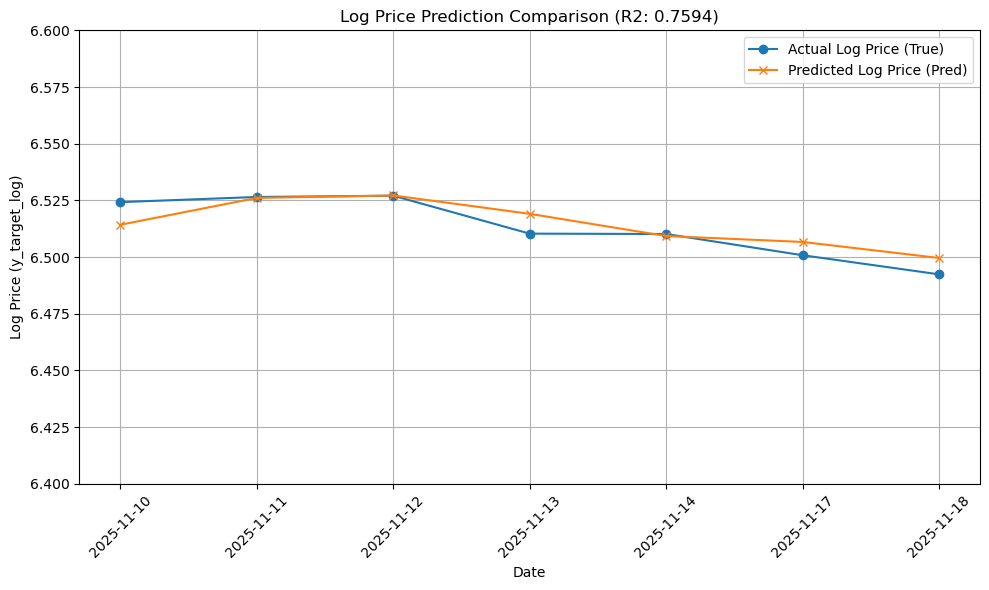

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# 실제 로그 레벨 값
plt.plot(result_df.index, result_df['log_true'], label='Actual Log Price (True)', marker='o')
# 예측 로그 레벨 값
plt.plot(result_df.index, result_df['log_pred'], label='Predicted Log Price (Pred)', marker='x')

plt.title(f'Log Price Prediction Comparison (R2: {r2_log:.4f})')
plt.xlabel('Date')
plt.ylabel('Log Price (y_target_log)')

# 👇 Y축 범위 조정 (예: 6.0에서 7.0까지)
plt.ylim(6.4, 6.6)

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()